# GAE, VGAE
参考  
https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html?highlight=vgae#torch_geometric.nn.models.VGAE  
https://www.mattari-benkyo-note.com/2022/05/23/pytorch-geometric-vgae/  


In [57]:
# Install required packages.
import os
import torch
import numpy as np
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.1+cpu


In [21]:
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), 
                     with_labels=False, node_color=color, cmap='Set2')
    plt.show()

def visualize_embedding(h: torch.Tensor, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:,0], h[:,1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

karate club データをダウンロード

In [2]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [3]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges/data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum())/data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self loops: False
Is undirected: True


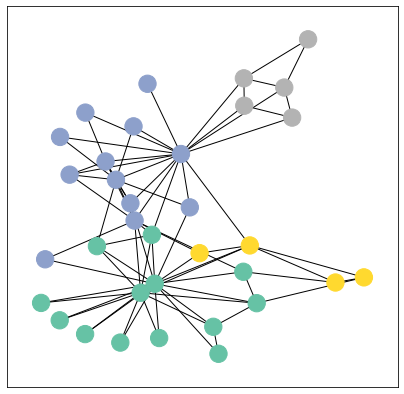

In [6]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

VGAE を作成。VGAE は encoder を代入して利用するモジュール。

In [40]:
import torch
from torch_geometric.nn import GCNConv, VGAE

class VGAE_Encoder(torch.nn.Module):
    def __init__(self, mid_channels, out_channels):
        super(VGAE_Encoder, self).__init__()
        torch.manual_seed(1234)
        self.gcn0 = GCNConv(dataset.num_features, mid_channels)
        self.conv_mu = GCNConv(mid_channels, out_channels)
        self.conv_logstd = GCNConv(mid_channels, out_channels)

    def forward(self, x, edge_index):
        h = self.gcn0(x, edge_index).relu()

        return self.conv_mu(h, edge_index), self.conv_logstd(h, edge_index)

model = VGAE(VGAE_Encoder(4, 2))
print(model)

VGAE(
  (encoder): VGAE_Encoder(
    (gcn0): GCNConv(34, 4)
    (conv_mu): GCNConv(4, 2)
    (conv_logstd): GCNConv(4, 2)
  )
  (decoder): InnerProductDecoder()
)


2次元に埋め込み（学習なし）

Embedding shape: [34, 2]


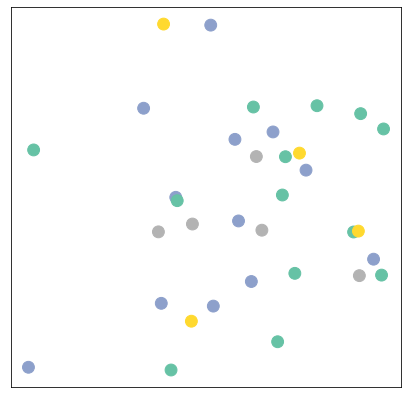

In [96]:
model = VGAE(VGAE_Encoder(4, 2))

z = model.encode(data.x, data.edge_index)
print(f'Embedding shape: {list(z.shape)}')
visualize_embedding(z, color=data.y)

2次元に埋め込み（学習あり）

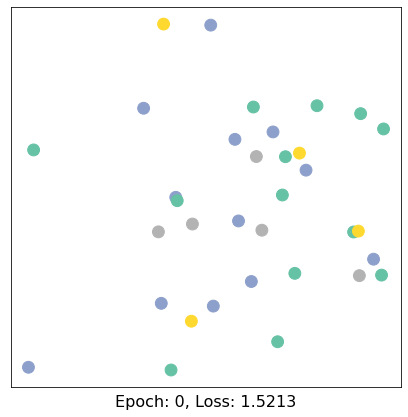

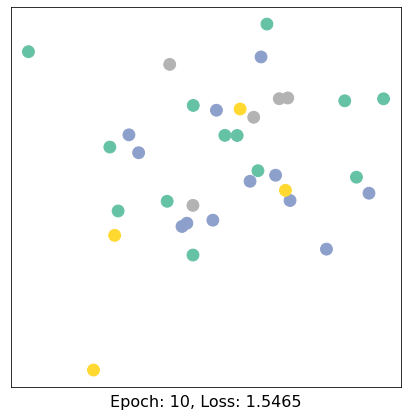

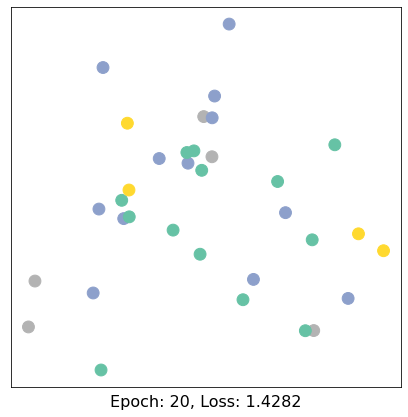

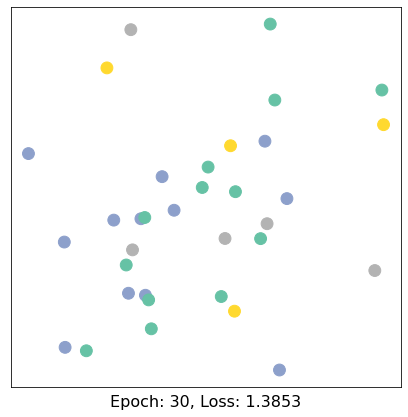

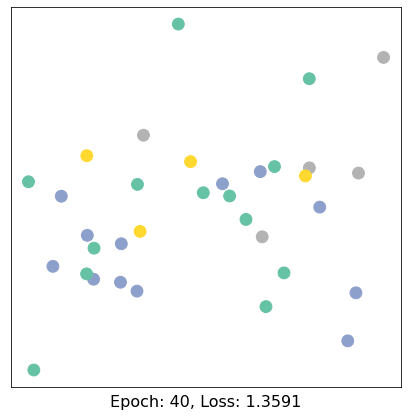

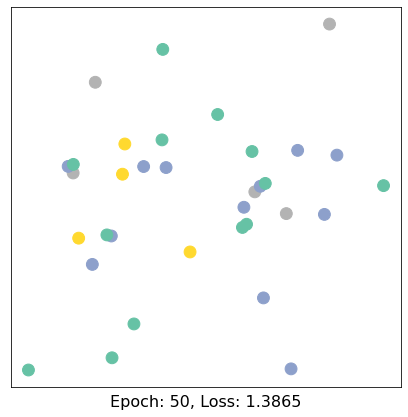

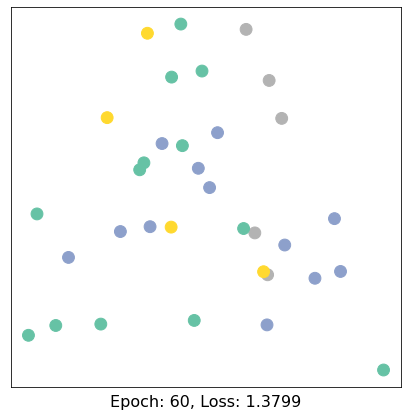

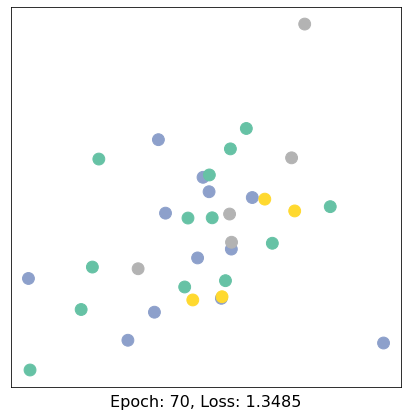

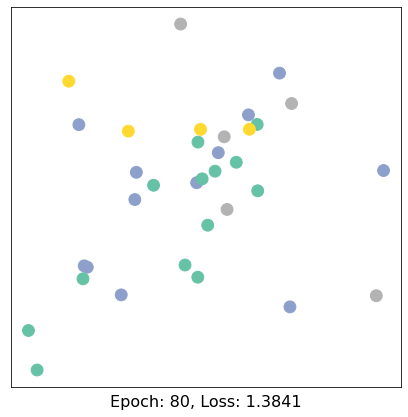

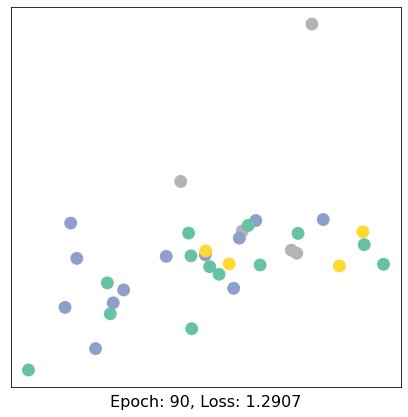

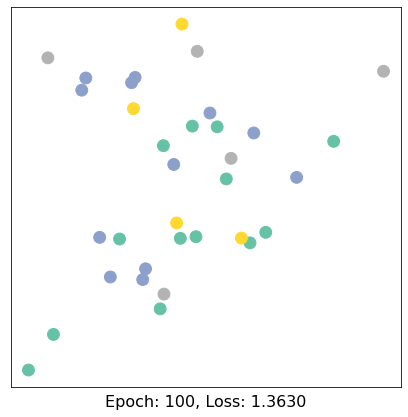

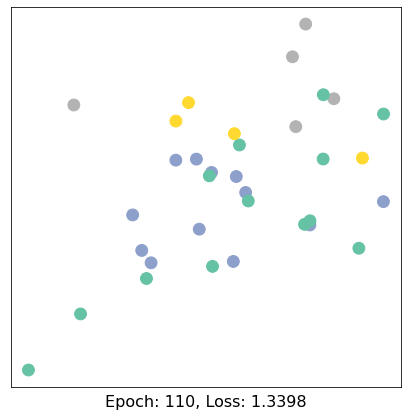

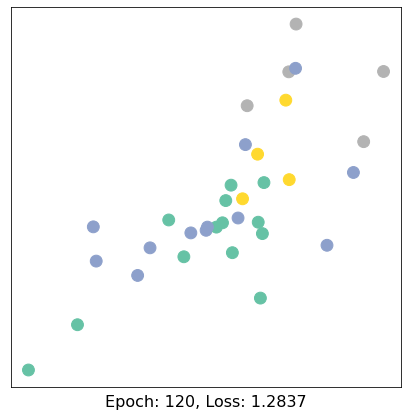

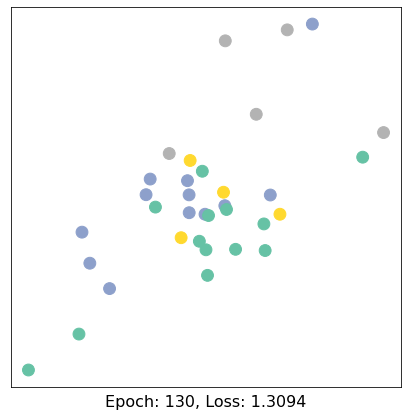

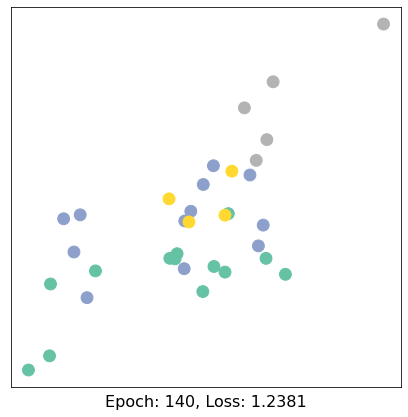

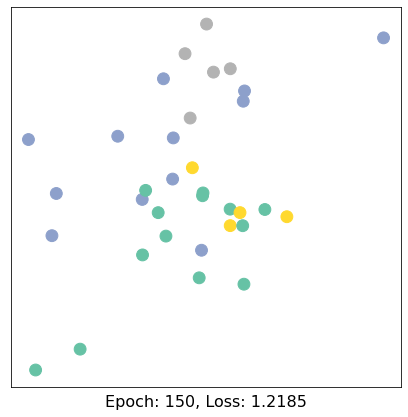

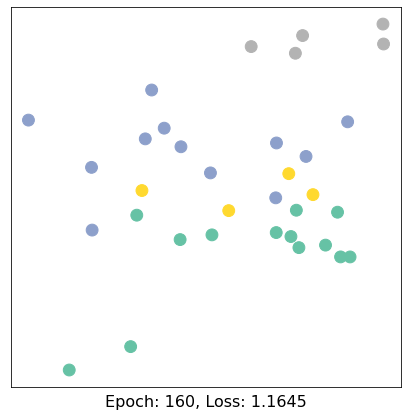

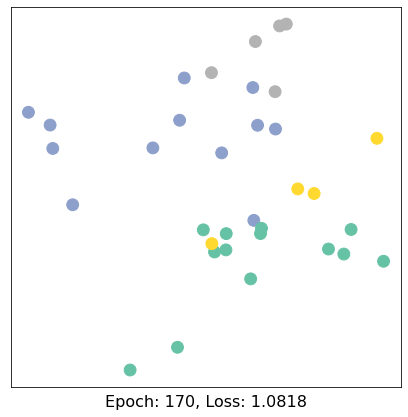

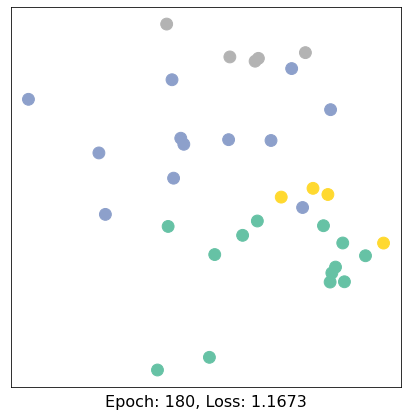

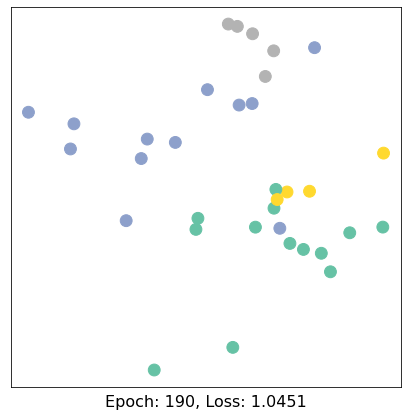

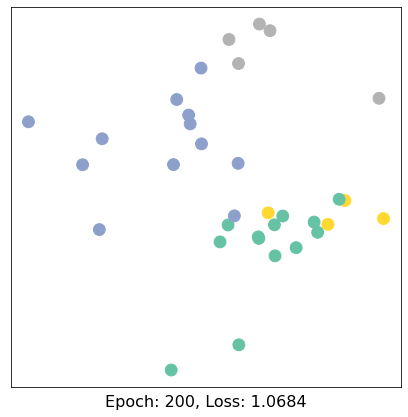

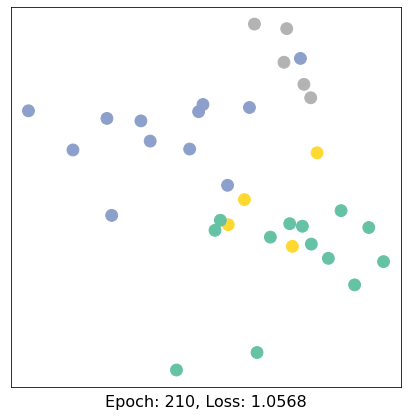

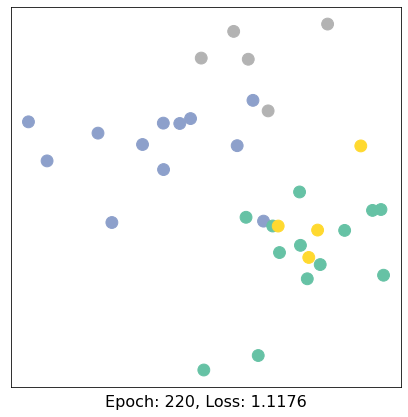

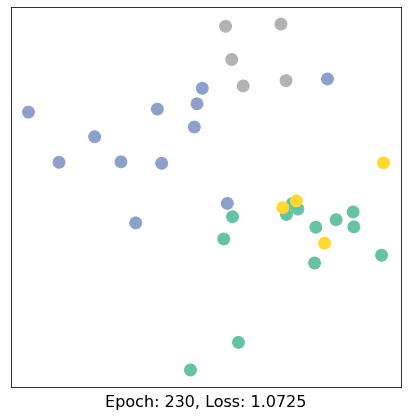

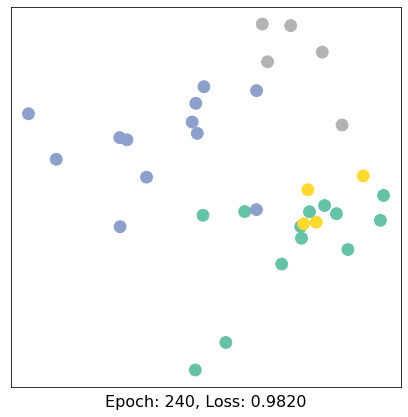

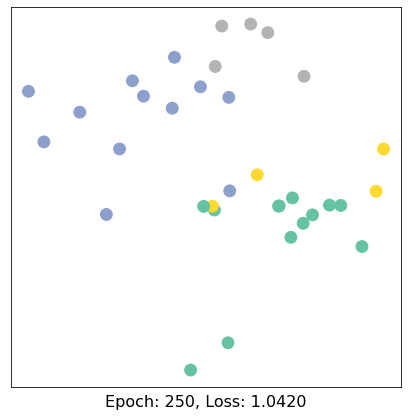

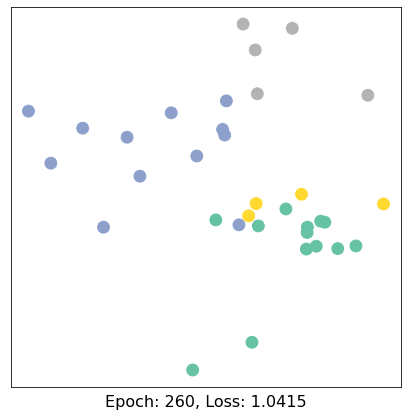

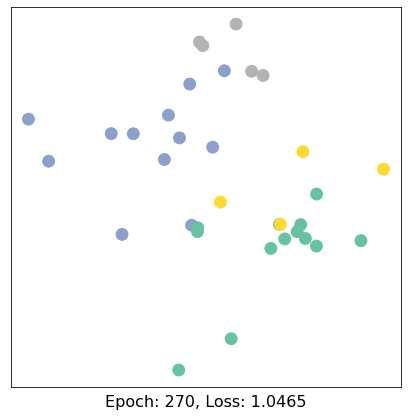

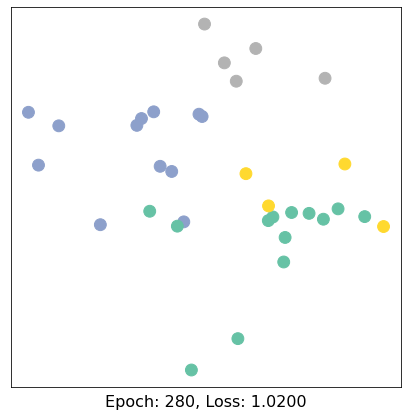

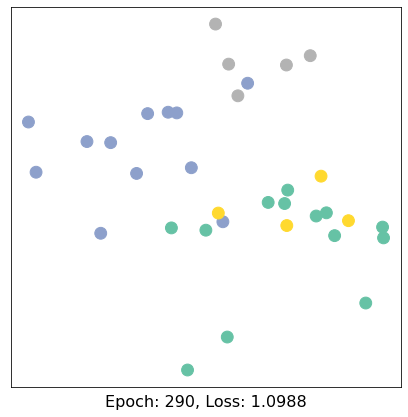

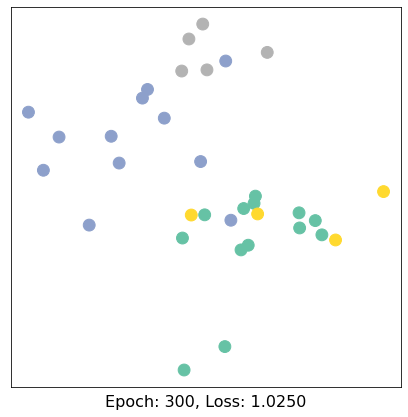

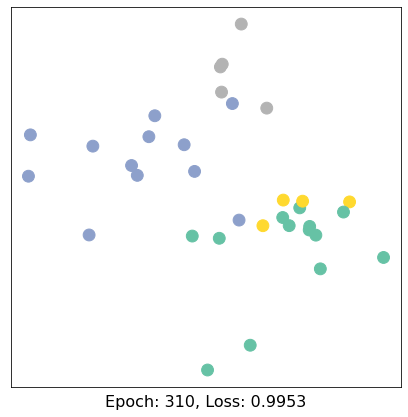

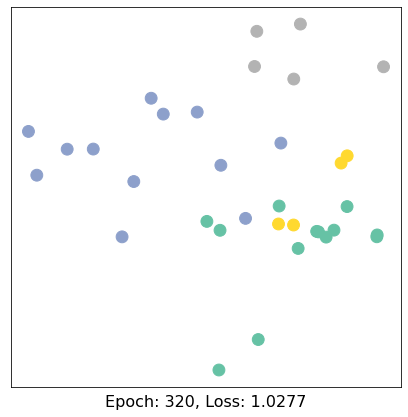

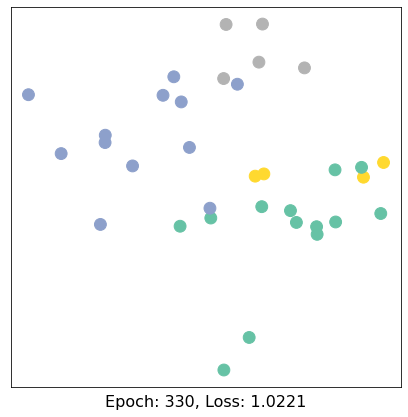

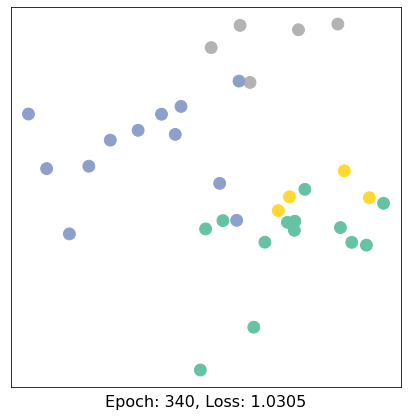

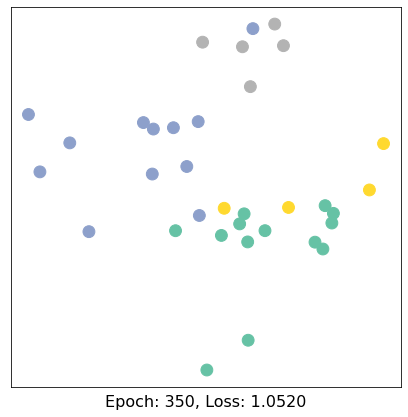

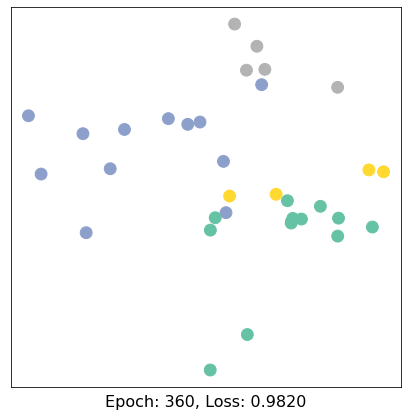

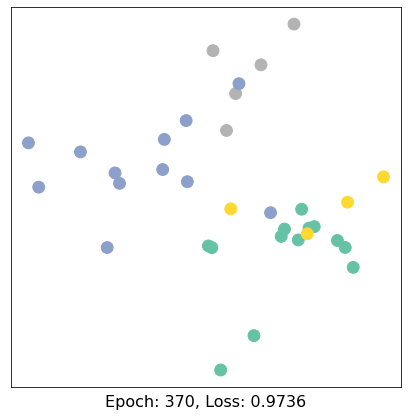

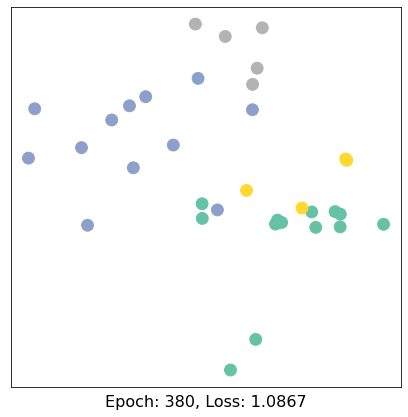

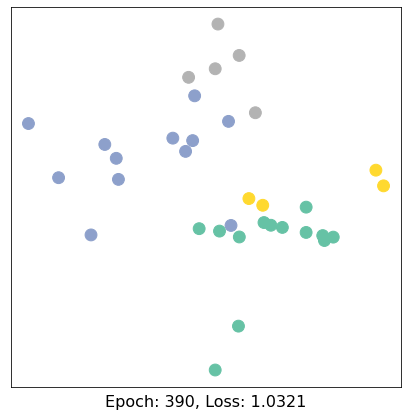

In [36]:
import time

model = VGAE(VGAE_Encoder(4, 2))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 

for epoch in range(0, 400):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    recon_loss = model.recon_loss(z, data.edge_index)
    kl_loss = (1 / data.num_nodes) * model.kl_loss()
    loss = recon_loss + kl_loss
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        visualize_embedding(z, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

潜在ベクトルの次元を4に増やし、復号まで実行してみる。

In [47]:
model = VGAE(VGAE_Encoder(4, 4))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(0, 400):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    recon_loss = model.recon_loss(z, data.edge_index)
    kl_loss = (1 / data.num_nodes) * model.kl_loss()
    loss = recon_loss + kl_loss
    loss.backward()
    optimizer.step()


a = model.decode(z, data.edge_index)
a

tensor([0.3700, 0.7304, 0.5385, 0.3774, 0.5877, 0.4700, 0.3198, 0.5895, 0.4770,
        0.4006, 0.3498, 0.4783, 0.5000, 0.5451, 0.3257, 0.6571, 0.3700, 0.4526,
        0.5945, 0.5520, 0.4631, 0.3353, 0.4104, 0.6139, 0.5271, 0.7304, 0.4526,
        0.5921, 0.1703, 0.8227, 0.5675, 0.4081, 0.7090, 0.8346, 0.9382, 0.5385,
        0.5945, 0.5921, 0.5616, 0.5879, 0.3335, 0.3774, 0.6442, 0.6068, 0.5877,
        0.8343, 0.7226, 0.9708, 0.4700, 0.6442, 0.8343, 0.7882, 0.3198, 0.5520,
        0.1703, 0.5616, 0.5895, 0.8227, 0.7247, 0.8997, 0.9419, 0.5675, 0.7444,
        0.4770, 0.6068, 0.7226, 0.4006, 0.3498, 0.5879, 0.4783, 0.4631, 0.4081,
        0.3335, 0.5777, 0.9195, 0.9474, 0.8161, 0.8441, 0.9708, 0.7882, 0.5000,
        0.3353, 0.9524, 0.9752, 0.5451, 0.4104, 0.2238, 0.8981, 0.9413, 0.3257,
        0.6139, 0.9098, 0.9457, 0.5724, 0.7454, 0.8038, 0.9508, 0.9730, 0.5424,
        0.5219, 0.5865, 0.5724, 0.5424, 0.5435, 0.6220, 0.7824, 0.7090, 0.7454,
        0.5219, 0.9333, 0.8346, 0.7494, 

ノードの組が閾値以上のスコアをもつならば、枝を張る

In [94]:
all_nodes = np.array(range(data.num_nodes))
all_edges = np.array([[[u, v] for v in all_nodes if u != v] for u in all_nodes]).reshape([-1, 2])
all_edges = torch.tensor(all_edges, dtype=torch.long).t().contiguous()
print(all_edges)

thr = 0.7
a = model.decode(z, all_edges)
edges = all_edges.t()[a > thr].t()

tensor([[ 0,  0,  0,  ..., 33, 33, 33],
        [ 1,  2,  3,  ..., 30, 31, 32]])
